# 1 Mcculloch Pitts

In [ ]:
import numpy as np


class MccullochPitts:
    def __init__(self, pos_weight, neg_weight, excitatory_list, activation_threshold=0):
        """
        A connection path is excitatory if the weight on the path is positive; other-
        wise it is inhibitory. All excitatory connections into a particular neuron have
        the same weights. (Laurene V. Fausett p27)
        """
        self.pos_weight = pos_weight
        self.neg_weight = neg_weight
        self.activation_threshold = activation_threshold
        self.excitatory_list = excitatory_list
    
    def activation_function(self, g):
        """ 
        The activation of a McCulloch-Pitts neuron is binary. That is, at any time
        step, the neuron either fires (has an activation of 1) or does not fire (has an
        activation of 0). 
        Each neuron has a fixed threshold such that if the net input to the neuron
        is greater than the threshold, the neuron fires.
        (Laurene V. Fausett p26, 27)
        """
        return g >= self.activation_threshold
    
    def forward(self, inputs: list):
        assert(len(inputs) == len(self.excitatory_list))
        sum = 0
        for input, excitatory in zip(inputs, self.excitatory_list):
            if excitatory:
                sum += input * self.pos_weight
            else:
                sum += input * self.neg_weight
        return self.activation_function(sum)

In [ ]:
class AndGate(MccullochPitts):
    def __init__(self):
        super().__init__(pos_weight=1, neg_weight=0, 
                         excitatory_list=[1, 1], activation_threshold=2)
        
class OrGate(MccullochPitts):
    def __init__(self):
        super().__init__(pos_weight=2, neg_weight=0, 
                         excitatory_list=[1, 1], activation_threshold=2)
        
class XorGate():
    def forward(self, inputs: list):
        assert(len(inputs) == 2)
        z1 = MccullochPitts(pos_weight=2, neg_weight=-1, 
                            excitatory_list=[1, 0], 
                            activation_threshold=2).forward(inputs)
        z2 = MccullochPitts(pos_weight=2, neg_weight=-1, 
                            excitatory_list=[0, 1], 
                            activation_threshold=2).forward(inputs)
        y = MccullochPitts(pos_weight=2, neg_weight=0, 
                            excitatory_list=[1, 1], 
                            activation_threshold=2).forward([z1, z2])
        return y

In [ ]:
def full_adder_1bit(A, B, Cin=0):
    z1 = XorGate().forward([A, B])
    S = XorGate().forward([z1, Cin])
    z2 = AndGate().forward([z1, Cin])
    z3 = AndGate().forward([A, B])
    C = OrGate().forward([z2, z3])
    return S, C

def full_adder_2bit(A1, A0, B1, B0, Cin=0):
    S0, Cmid = full_adder_1bit(A0, B0)
    S1, C = full_adder_1bit(A1, B1, Cmid)
    return S1, S0, C

full_adder_2bit(1, 1, 1, 0)

(False, True, True)

In [ ]:
import itertools
binaries = list(itertools.product([0, 1], repeat=4))
print(" A1 A0 B1 B0 ->C S1S0")
for b in binaries:
    S1, S0, C = full_adder_2bit(*b)
    print(b, " ", C*1, S1*1, S0*1)

 A1 A0 B1 B0 ->C S1S0
(0, 0, 0, 0)   0 0 0
(0, 0, 0, 1)   0 0 1
(0, 0, 1, 0)   0 1 0
(0, 0, 1, 1)   0 1 1
(0, 1, 0, 0)   0 0 1
(0, 1, 0, 1)   0 1 0
(0, 1, 1, 0)   0 1 1
(0, 1, 1, 1)   1 0 0
(1, 0, 0, 0)   0 1 0
(1, 0, 0, 1)   0 1 1
(1, 0, 1, 0)   1 0 0
(1, 0, 1, 1)   1 0 1
(1, 1, 0, 0)   0 1 1
(1, 1, 0, 1)   1 0 0
(1, 1, 1, 0)   1 0 1
(1, 1, 1, 1)   1 1 0


# 2 ADALINE

## a) Data Distribution + Scatter Plot

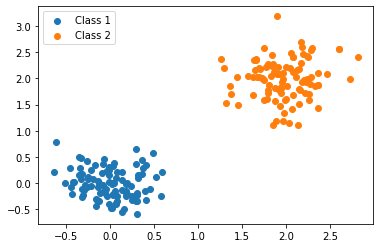

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


c1_x = np.random.normal(loc=0, scale=0.3, size=100)
c1_y = np.random.normal(loc=0, scale=0.3, size=100)
c2_x = np.random.normal(loc=2, scale=0.3, size=100)
c2_y = np.random.normal(loc=2, scale=0.3, size=100)
plt.scatter(x=c1_x, y=c1_y, label="Class 1")
plt.scatter(x=c2_x, y=c2_y, label="Class 2")
plt.legend()

## b) Adaline Training

In [39]:
from tqdm.auto import tqdm


class Adaline():
    def __init__(self, in_features=2, lr=0.2, stop_tolerance=1e-10):
        """
        Initialize weights. (Small random values are usually used.)
        Set learning rate alpha (Laurene V. Fausett p82)
        """
        self.weights = np.random.random(in_features)
        self.bias = np.random.random()
        self.lr = lr
        self.stop_tolerance = stop_tolerance
        self.loss_history = []
    
    def forward(self, xi):
        """Compute net input to output unit: y_in = b + E xi.wi """
        net = self.bias + np.dot(xi, self.weights)
        return net
    
    def step(self, xi, net, target):
        """
        Update bias and weights, i = 1, . . . , n:
        b(new) = b(old) + a(t — y_in).
        wi(new) = wi(old) + a(t — y_in)xi . (y_in=net)
        """
        grad = target - net
        self.bias += self.lr * grad
        self.weights += self.lr * grad * xi
        return max(abs(self.lr * grad), max(abs(self.lr * grad * xi)))

    def calc_loss(self, targets, nets):
        return np.mean(1/2 * (np.array(targets) - np.array(nets))**2)

    def train(self, X, Y, max_epochs=10):
        """If the largest weight change that occurred in Step 2 is
        smaller than a specified tolerance, then stop; otherwise continue.
        """
        self.loss_history = []
        max_change = 10e10
        from sklearn.utils import shuffle
        X, Y = shuffle(X, Y, random_state=0)
        for epoch in tqdm(range(max_epochs)):
            targets, nets = [], []
            for x, y in zip(X, Y):
                net = self.forward(x)
                step_max_change = self.step(x, net, y)
                max_change = min(max_change, step_max_change)
                targets.append(y)
                nets.append(net)
            self.loss_history.append(self.calc_loss(targets, nets))
            if max_change < self.stop_tolerance:
                print(max_change, self.stop_tolerance)
                break

    def activation_function(self, g):
        return 1 if g >= 0 else -1

    def predict(self, X):
        Y = []
        for x in X:
            net = self.forward(x)
            Y.append(self.activation_function(net))
        return np.array(Y)

    def plot_loss(self):
        plt.plot(self.loss_history, label="1/2 * (target - net)**2")
        plt.legend()
        plt.title("Adaline Loss History")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    
    def plot_scatter(self, X, Y):
        plt.scatter(
            X[:, 0],
            X[:, 1],
            c=Y,
            cmap='tab20b',
            edgecolors="k",
            alpha=0.95,
        )
        h = 0.01  # step size in the mesh
        xx, yy = np.meshgrid(np.arange(min(X[:, 0]) - 2, max(X[:, 0]), h) + 1, 
                                np.arange(min(X[:, 1]) - 1, max(X[:, 1]), h) + 1)
        # Plot the decision boundary
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        cm = plt.cm.tab20b
        plt.contourf(xx, yy, Z, cmap=cm, alpha=0.5)
        plt.title("Adaline Decision Boundry")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

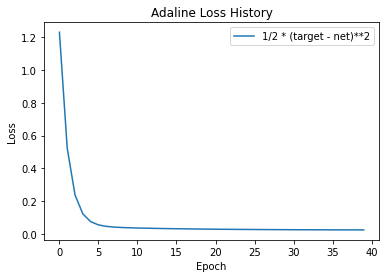

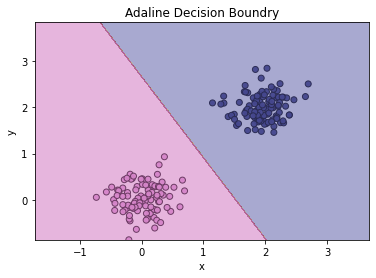

In [40]:
import matplotlib.pyplot as plt
import numpy as np

def prepare_data(c1_x, c1_y, c2_x, c2_y):
    X = np.concatenate([np.stack([c1_x, c1_y], axis=-1),
                          np.stack([c2_x, c2_y], axis=-1)])
    Y = np.concatenate([np.ones(c1_x.shape), np.ones(c2_x.shape)*-1])
    return X, Y

c1_x = np.random.normal(loc=0, scale=0.3, size=100)
c1_y = np.random.normal(loc=0, scale=0.3, size=100)
c2_x = np.random.normal(loc=2, scale=0.3, size=100)
c2_y = np.random.normal(loc=2, scale=0.3, size=100)      
X, Y = prepare_data(c1_x, c1_y, c2_x, c2_y)
adaline = Adaline(in_features=2, lr=5e-4)
adaline.train(X, Y, max_epochs=40)
adaline.plot_loss()
plt.show()
adaline.plot_scatter(X, Y)

## c) Different Data

  0%|          | 0/50 [00:00<?, ?it/s]

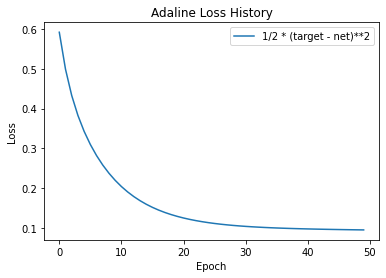

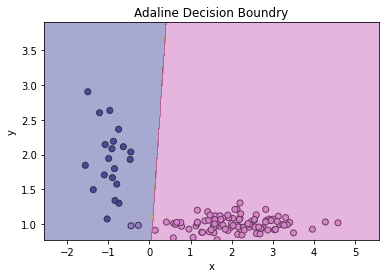

In [41]:
c1_x = np.random.normal(loc=2, scale=1, size=100)
c1_y = np.random.normal(loc=1, scale=0.1, size=100)
c2_x = np.random.normal(loc=-1, scale=0.4, size=20)
c2_y = np.random.normal(loc=2, scale=0.4, size=20)
X, Y = prepare_data(c1_x, c1_y, c2_x, c2_y)
adaline = Adaline(in_features=2, lr=5e-4)
adaline.train(X, Y, max_epochs=50)
adaline.plot_loss()
plt.show()
adaline.plot_scatter(X, Y)

# 3 Madaline

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

## b) Load & Plot

In [6]:
df = pd.read_csv("Question3.csv", header=None)
df[2] = df[2].replace(0, -1)
df

,0,1,2
0,0.459694,-0.470583,-1.0
1,0.797385,-0.343030,-1.0
2,0.235270,0.961296,-1.0
3,0.765453,-0.177644,-1.0
4,-0.335577,-0.313893,-1.0
...,...,...,...
195,0.744066,-1.206548,1.0
196,-0.457547,1.286227,1.0
197,-1.020000,-0.783926,1.0
198,1.363429,-0.800250,1.0


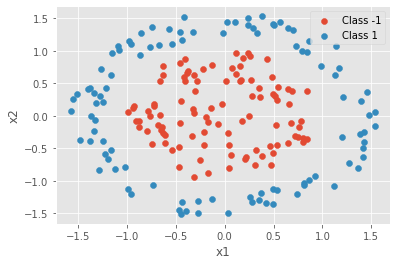

In [7]:
with plt.style.context("ggplot"):
    plt.scatter(x=df.loc[df[2] == -1][0], 
                y=df.loc[df[2] == -1][1], label="Class -1")
    plt.scatter(x=df.loc[df[2] == 1][0], 
                y=df.loc[df[2] == 1][1], label="Class 1")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()

## c) Train Madaline

### Hidden Units: 3 ###


  0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        -1.0       0.90      0.90      0.90       100
         1.0       0.90      0.90      0.90       100

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



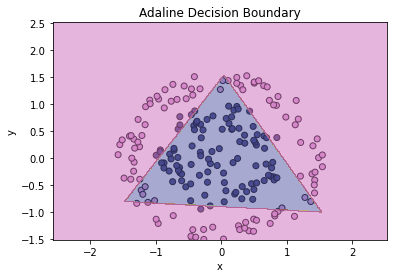

### Hidden Units: 4 ###


  0%|          | 0/100 [00:00<?, ?it/s]

Early Stopping
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       100
         1.0       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



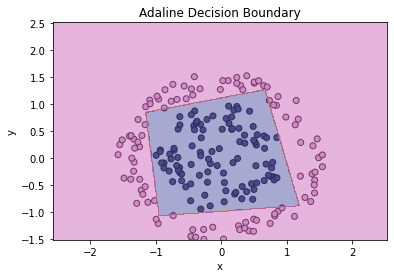

### Hidden Units: 8 ###


  0%|          | 0/100 [00:00<?, ?it/s]

Early Stopping
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       100
         1.0       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



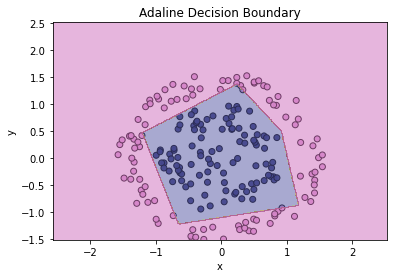

In [97]:
class Madaline:
    def __init__(self, in_features=2, hidden_units=3, lr=0.2, stop_tolerance=1e-10):
        """
        Initialize weights:
        Weights v i and v2 and the bias b3 are set as described;
        small random values are usually used for ADALINE weights.
        """
        self.weights = np.random.random([in_features, hidden_units])
        self.output_weights = np.array([1/hidden_units] * hidden_units)
        self.bias = np.random.random(hidden_units)
        self.output_bias = (hidden_units - 1)/hidden_units
        self.lr = lr
        self.stop_tolerance = stop_tolerance
        self.loss_history = []

        self.hidden_units = hidden_units
        self.in_features = in_features
    
    def activation_function(self, g):
        return ((g >= 0) - 0.5) * 2  # [0,1] -> [-1, 1]

    def forward(self, x):
        """Compute net input to each hidden ADALINE unit
        Determine output of each hidden ADALINE unit
        Determine output of net
        """
        x = x.reshape(1, len(x))  # (1, i)
        z_in = self.bias + x @ self.weights  # (1, i)@(i, h)->(1, h)
        z = self.activation_function(z_in)
        y_in = self.output_bias + z @ self.output_weights # (1, h)@(h, 1)->(1)
        y = self.activation_function(y_in)[0]
        # print("x", x)
        # print("b", self.bias)
        # print("w", self.weights)
        # print("@", (x @ self.weights).shape)
        
        return y, z_in, y_in

    def predict(self, X):
        Y = []
        for x in X:
            y, z_in, y_in = self.forward(x)
            Y.append(y)
        return np.array(Y)

    def eval(self, X, Y):
        preds = []
        for x, t in zip(X, Y):
            y, z_in, y_in = self.forward(x)
            preds.append(y)
        from sklearn.metrics import classification_report
        print(classification_report(Y, preds))

    def step(self, y, z_in, t, x):
        z_in = z_in[0]  # flatten
        if t != y:  # If t = y, no weight updates are performed
            # print(z_in, t, y)
            if t == 1:  # If t = 1, then update weights on Zj, the unit whose net input is closest to 0
                close_zero_idx = np.argmin(abs(z_in))
                self.weights[:, close_zero_idx] += self.lr * (1 - z_in[close_zero_idx]) * x
                self.bias[close_zero_idx] += self.lr * (1 - z_in[close_zero_idx])
            elif t == -1:  # If t = —1, then update weights on all units Zk that have positive net input
                for h in range(self.hidden_units):
                    if z_in[h] > 0:
                        self.weights[:, h] += self.lr * (-1 - z_in[h]) * x
                        self.bias[h] += self.lr * (-1 - z_in[h])
            return True
        return False

    def train(self, X, Y, max_epochs=40):
        """If the largest weight change that occurred in Step 2 is
        smaller than a specified tolerance, then stop; otherwise continue.
        """
        self.loss_history = []
        from sklearn.utils import shuffle
        X, Y = shuffle(X, Y, random_state=42)
        for epoch in tqdm(range(max_epochs)):
            # self.plot_scatter(X, Y)
            targets, nets, changes = [], [], []
            for x, t in zip(X, Y):
                y, z_in, y_in = self.forward(x)
                changes.append(self.step(y, z_in, t, x))
                targets.append(t)
                nets.append(y_in)
            self.loss_history.append(self.calc_loss(targets, nets))
            if not any(changes):
                print("Early Stopping")
                break
            
    def calc_loss(self, targets, nets):
        return np.mean(1/2 * (np.array(targets) - np.array(nets))**2)

    def plot_loss(self):
        plt.plot(self.loss_history, label="1/2 * (target - net)**2")
        plt.legend()
        plt.title("Adaline Loss History")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    def plot_scatter(self, X, Y):
        plt.scatter(
            X[:, 0],
            X[:, 1],
            c=Y,
            cmap='tab20b',
            edgecolors="k",
            alpha=0.95,
        )
        h = 0.01  # step size in the mesh
        xx, yy = np.meshgrid(np.arange(min(X[:, 0]) - 2, max(X[:, 0]), h) + 1, 
                                np.arange(min(X[:, 1]) - 1, max(X[:, 1]), h) + 1)
        # Plot the decision boundary
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        cm = plt.cm.tab20b
        plt.contourf(xx, yy, Z, cmap=cm, alpha=0.5)
        plt.title("Adaline Decision Boundary")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()

for n in [3, 4, 8]:
    print(f"### Hidden Units: {n} ###")
    madaline = Madaline(in_features=2, hidden_units=n, lr=0.2)
    madaline.train(X=np.array(df[[0, 1]]), Y=np.array(df[2]), max_epochs=100)
    # madaline.plot_loss()
    madaline.eval(X=np.array(df[[0, 1]]), Y=np.array(df[2]))
    madaline.plot_scatter(X=np.array(df[[0, 1]]), Y=np.array(df[2]))

In [100]:
madaline.predict(np.array([[0, 0]]))

array([-1.])